In [4]:
# Task:
# postprocessing analysis
# use Joback method (using functional groups to calc. Cv) 
# find the rep. with qm9 and save the final file in a .csv file
# Joback has 6% error on qm9 values
import warnings
warnings.filterwarnings('ignore')
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
from rdkit import Chem
print ("!!!!!!!!!!!!!!!!!!!!!we are after importing rdkit!!!!!!!!!!!!!!!!!!")

from thermo.joback import Joback
import numpy as np
import pandas as pd
from numpy import ndarray
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# loading SMILES data using Chainer Chemistry
from chainer_chemistry.datasets.molnet import get_molnet_dataset
from chainer_chemistry.datasets.numpy_tuple_dataset import NumpyTupleDataset
from chainer_chemistry.dataset.preprocessors import GGNNPreprocessor

!!!!!!!!!!!!!!!!!!!!!we are after importing rdkit!!!!!!!!!!!!!!!!!!


length of validated SMILES by Joback 4175 Vs. total gen_SMILES 4336
(4175, 2)
(4175, 5)
mean error Joback(gen_SMILES) Vs. des. value:  0.15238292345102356
mean error Joback(gen_SMILES) Vs. Predicted from regressor:  0.10445027984715263
the first smile in val_accurate:  C#CC1C=CC(N)CC1
mean error Joback(gen_SMILES) Vs.Predicted from regressor (for accurate Cv(<10%):  0.10445027984715263
mean error Joback(gen_SMILES) Vs.Desired from regressor (for accurate Cv(<10%):  0.15238292345102356


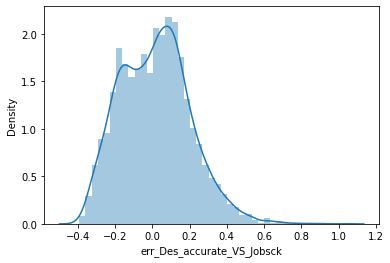

In [5]:
# load the generated SMILES from the RCGAN Model
csv_name = './../experiments/regular_9HA_6b6latent/Regular_noscreen.csv'
gen_SMILES = pd.read_csv(csv_name)

# pick the samples with available Joback values
jobacks = []
validated = []
valid_ids = []
for count, s in enumerate(gen_SMILES['SMILES'].values):
    try:
        J = Joback(s)
        jobacks.append(J.Cpig(298.15) * 0.2390057361)
        validated.append(s)
        valid_ids.append(count)     
    except:
        pass
print ("length of validated SMILES by Joback {} Vs. total gen_SMILES {}".\
        format(len(validated), len(gen_SMILES['SMILES'])))

val = {}
val['jobacks'] = jobacks
val['SMILES'] = validated
val = pd.DataFrame(val)
gen_SMILES2 = gen_SMILES.iloc[valid_ids, :]
gen_SMILES2['jobacks'] = jobacks
print (val.shape)
print (gen_SMILES2.shape)

#val = pd.merge(val, gen_SMILES2, how = 'right', on = 'SMILES')
#print (val)
# error using Joback method mean
gen_SMILES2['Err_joback_pred'] = np.abs(
    (gen_SMILES2['pred_cv'].values - gen_SMILES2['jobacks'].values)/  
     gen_SMILES2['jobacks'].values)

gen_SMILES2['Err_joback_des'] = np.abs(
    (gen_SMILES2['des_cv'].values - gen_SMILES2['jobacks'].values)/
     gen_SMILES2['jobacks'].values)

# error using Joback method mean 
# Joback vs. Des. Cv
mean_err = np.mean(np.abs(
    (gen_SMILES2['des_cv'].values - gen_SMILES2['jobacks'].values)/ 
     gen_SMILES2['jobacks'].values))
print ("mean error Joback(gen_SMILES) Vs. des. value: ", mean_err)

# Joback vs. pred. Cv by Regressor
mean_err = np.mean(np.abs(
    (gen_SMILES2['pred_cv'].values - gen_SMILES2['jobacks'].values)/ 
     gen_SMILES2['jobacks'].values))
print ("mean error Joback(gen_SMILES) Vs. Predicted from regressor: ", mean_err)

gen_SMILES2.reset_index(drop = True, inplace = True)

csv_name = csv_name.replace('.csv', '') 
gen_SMILES2.to_csv('{}_jobackadded.csv'.format(csv_name), index = False)

# find the best candidates in generated SMILES (criteria: <0.05)
val_accurate = pd.DataFrame({'SMILES': [],
                             'des_cv': [],
                             'pred_cv': [],
                             'jobacks': []})
accurate = []
"""
for i, s in enumerate (val['SMILES'].values):
    if (np.abs((val['des_cv'].values[i] - val['jobacks'].values[i]) / val['jobacks'].values[i]) < 0.07 and
        np.abs((val['des_cv'].values[i] - val['jobacks'].values[i]) / val['jobacks'].values[i]) > 0.03 ) :
        accurate.append(i)
print (accurate)
"""
for i, s in enumerate (gen_SMILES2['SMILES'].values):
    if np.abs((gen_SMILES2['des_cv'].values[i] - 
               gen_SMILES2['jobacks'].values[i]) / 
               gen_SMILES2['jobacks'].values[i]) > 0:
        accurate.append(i)
#print (accurate)

for ii, a in enumerate (accurate):
    #print (" i and a from accurate",ii, a)
    val_accurate.loc[ii,:] = gen_SMILES2.iloc[a,:]
#print (val_accurate)
print ("the first smile in val_accurate: ",val_accurate['SMILES'].values[0])
for i, s in enumerate (val_accurate['SMILES'].values):
    #print (s)
    m = Chem.MolFromSmiles(s)
    ss = Chem.MolToSmiles(m)
    val_accurate['SMILES'].values[i] = ss
    #print (val_accurate['SMILES'].values[i])
    #print (ss)
#print (val_accurate)

sort_val_accurate = val_accurate.sort_values ('des_cv')
#print (sort_val_accurate) 

# accuracy of the the model Joback vs. predicted and desired Cv (accurate < 5%)
mean_err = np.mean(np.abs((val_accurate['pred_cv'].values - 
                           val_accurate['jobacks'].values) / 
                           val_accurate['jobacks'].values))
print ("mean error Joback(gen_SMILES) Vs.Predicted from regressor (for accurate Cv(<10%): ", mean_err)


mean_err = np.mean(np.abs((val_accurate['des_cv'].values -
                           val_accurate['jobacks'].values) /
                           val_accurate['jobacks'].values))
print ("mean error Joback(gen_SMILES) Vs.Desired from regressor (for accurate Cv(<10%): ", mean_err)


num_acc_l0p1 = np.sum(np.abs((gen_SMILES2['des_cv'].values - 
                              gen_SMILES2['jobacks'].values) / 
                              gen_SMILES2['jobacks'].values) < 0.1)

plt.scatter(gen_SMILES2['des_cv'].values, gen_SMILES2['jobacks'].values)
plt.savefig("Desired_VS_joback.png")

plt.clf()
plt.scatter(val_accurate['des_cv'].values, val_accurate['jobacks'].values)
plt.title("Accurate Desired Cv vs. Joback Cv")
plt.xlabel("Desired Cv")
plt.ylabel("Joback Cv")
plt.savefig("Desired_accurate_VS_joback.png")

plt.clf()
#sns.distplot(np.abs((val['des_cv'].values - val['jobacks'].values) / val['jobacks'].values))
sns.distplot(((gen_SMILES2['des_cv'].values - gen_SMILES2['jobacks'].values) / gen_SMILES2['jobacks'].values))

plt.savefig("err_Des_VS_Jobsck.png")

plt.clf()
err_Desacc_job = ((val_accurate['des_cv'].values - val_accurate['jobacks'].values) / val_accurate['jobacks'].values)
err_Desacc_job = pd.Series(err_Desacc_job, name="err_Des_accurate_VS_Jobsck")
sns.distplot(err_Desacc_job)
plt.savefig("err_Des_accurate_VS_Jobsck.png")
#1131/3020
"""
num_acc_l0p025 = np.sum(gen_SMILES['Err_pred_des'].values < 0.025, dtype = np.int32)
num_acc_0p025_0p05 =  np.sum((gen_SMILES['Err_pred_des'].values >= 0.025) & (gen_SMILES['Err_pred_des'].values < 0.05), dtype = np.int32)
num_acc_g0p05 =  np.sum(gen_SMILES['Err_pred_des'].values > 0.05, dtype = np.int32)
total = num_acc_l0p025 + num_acc_0p025_0p05 + num_acc_g0p05

print ("type of accurate l0p025: ", type (num_acc_l0p025))
print (num_acc_l0p025)

summ = float(gen_SMILES.shape[0])
print ("total SMILES is : {}".format(gen_SMILES.shape))
plt.figure(figsize = (5, 5))

plt.bar(['< 2.5%', '2.5% - 5%', '5% - 10%'],
        [num_acc_l0p025 / total, num_acc_0p025_0p05 / total,num_acc_g0p05 / total],
        color = ['green', 'blue', 'red'],
        alpha = 0.7)
plt.grid()
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("error_Distrib_5_2p5percent.png")
"""
val_accurate.reset_index(drop = True, inplace = True)

First SMILES in qm9 COC=Nc1ccco1
First SMILES in qm9 COC=Nc1ccco1
same generated SMILES compared to qm9 lib is:               SMILES   des_cv    pred_cv  Err_pred_des         cv
0     CC1CC2CC1(C)C2C  40.5736  34.010296      0.161763  37.379002
1     CCC1CC(C)(CC)O1  40.5736  34.010296      0.161763  40.035000
2       CCC1CCCC(C)O1  40.5736  34.010296      0.161763  37.824001
3       COCC1C(C)CC1C  40.5736  34.010296      0.161763  39.356998
4       CCC(C)CC1OC1C  40.5736  34.010296      0.161763  40.512001
...               ...      ...        ...           ...        ...
1652     CCC1(C)CCC1C  39.8674  34.010296      0.146915  36.655998
1653   C#CCCCC(C)(C)C  39.8674  34.010296      0.146915  43.023998
1654   O=CC(=O)C1COC1  39.8674  34.010296      0.146915  26.107000
1655    CCC1CC1(C)C=O  39.8674  34.010296      0.146915  33.831001
1656   C#CC1CCCC(O)C1  39.8674  34.010296      0.146915  35.276001

[1657 rows x 5 columns]
mean of rel diff BW Desired (sampled in design model) and cv

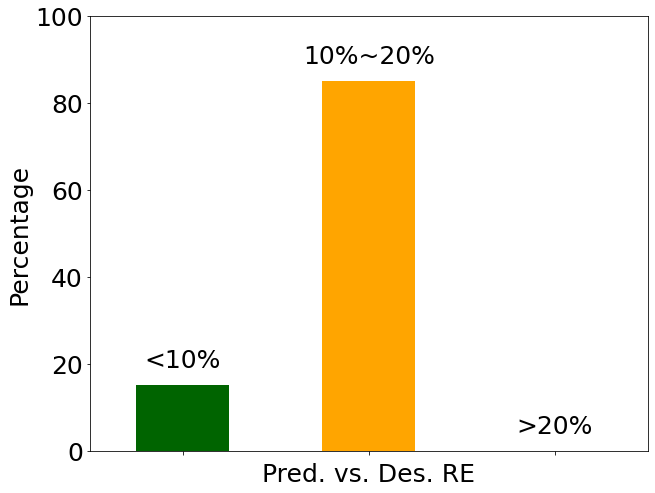

In [6]:
#val_accurate.to_csv('gen_new_noscreen_all_joback.csv', index = False)
preprocessor = GGNNPreprocessor()
"""

data = get_molnet_dataset('qm9',
                          labels = 'cv',
                          preprocessor = preprocessor,
                          return_smiles = True,
                          frac_train = 1.0,
                          frac_valid = 0.0,
                          frac_test = 0.0
                         )
""" 
with open('./../data/trainingsets/Data.pickle', 'rb') as f:
    data = pickle.load (f)

SMILES_ = data['smiles'][0]
print ('First SMILES in qm9', SMILES_[0])
SMILES = []

# save as canonical SMILES to find duplicates
# the gen smiles already converted to Canonical
for s in SMILES_:
    m = Chem.MolFromSmiles (s)
    ss = Chem.MolToSmiles(m)
    SMILES.append(ss)
#SMILES = SMILES.astype('str')
print ('First SMILES in qm9', SMILES[0])

data_SMILES = []
data_cv_ = []
for i, s in enumerate(SMILES):
    data_SMILES.append(s)
    data_cv_.append(data['dataset'][0][i][2][0])



data_cv = np.array(data_cv_)
data_SMILES = np.array(data_SMILES)

#gen_unique = gen_SMILES['SMILES'].values

data = {}
data['SMILES'] = data_SMILES
data['cv'] = data_cv_
data = pd.DataFrame(data)

# find the repetitives
database_samples = pd.merge(gen_SMILES, data, on = 'SMILES', how = 'inner')
print ( "same generated SMILES compared to qm9 lib is:{}".format(database_samples))
rep_smiles = database_samples['SMILES'].tolist()
for i in range(gen_SMILES.shape[0]):
    if (gen_SMILES['SMILES'][i] in rep_smiles):
        gen_SMILES = gen_SMILES.drop(i)

gen_SMILES.reset_index(drop=True, inplace=True)
csv_name = csv_name.replace('.csv', '')
gen_SMILES.to_csv('{}_qm9removed.csv'.format(csv_name), index = False)

# get the relative error of Desired Cv vs Cv from qm9 for generated SMILES that are repetitive and are in qm9
mean_rel_diff_desired_cvqm9 = np.mean(np.abs((database_samples['des_cv'].values -
                                              database_samples['cv'].values) / 
                                              database_samples['cv'].values))
print ("mean of rel diff BW Desired (sampled in design model) and cv from qm9: {}".
                                                 format(mean_rel_diff_desired_cvqm9))


mean_rel_diff_desired_cvqm9 = np.mean(np.abs((database_samples['pred_cv'].values
                       - database_samples['cv'].values) / database_samples['cv'].values))
print ("mean of rel diff BW Predicted (from regresor) and cv from qm9: {}".
                                                 format(mean_rel_diff_desired_cvqm9))

# plot the error bars <10%, <20%
re_less_10 = np.sum(gen_SMILES['Err_pred_des'].values <= 0.1)
print ('less than 10 % ', re_less_10, 'from total ', gen_SMILES.shape[0])
re_less_20_big_10 = np.sum( (gen_SMILES['Err_pred_des'].values > 0.1) &  (gen_SMILES['Err_pred_des'].values <= 0.2) )
print ('less than 20 larger than 10% ', re_less_20_big_10, 'from total ', gen_SMILES.shape[0])
re_big_20 = np.sum(gen_SMILES['Err_pred_des'].values > 0.2)
print ('larger than 20 % ', re_big_20, 'from total ', gen_SMILES.shape[0])
print ('total: ', re_less_10 + re_less_20_big_10 + re_big_20)
"""
plt.close()
plt.figure(figsize = (18, 10))
plt.bar(['< 10%', '10% - 20%', '>20%'],
        [re_less_10/len(gen_SMILES), re_less_20_big_10/len(gen_SMILES), re_big_20/len(gen_SMILES)],
        color = ['green', 'blue', 'red'],
        alpha = 0.7)

plt.close()
"""
plt.figure(figsize = (10, 8))
frequencies = [re_less_10/len(gen_SMILES)*100, re_less_20_big_10/len(gen_SMILES)*100, re_big_20/len(gen_SMILES)*100]
freq_series = pd.Series(frequencies)
ax = freq_series.plot(kind='bar', color = ['darkgreen', 'orange', 'magenta'])
rects = ax.patches
x_labels = [ ]
labels = ['<10%', '10%~20%', '>20%']

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 3, label,fontsize = 25,
            ha='center', va='bottom')
ax.set_xticklabels(x_labels)
plt.ylim(0,100)
plt.yticks(fontsize = 25)
plt.ylabel("Percentage", fontsize=25)
plt.xlabel("Pred. vs. Des. RE", fontsize=25)
plt.savefig('Err_pred_des_dist_3part.png', dpi=300)
